<a href="https://colab.research.google.com/github/Panashe1812/Masters-Project/blob/main/Master_Project_model_training_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function, division
import os
import torch, torchvision
from torch import nn, optim
from torch.optim import lr_scheduler
#import torchvision
from tqdm import tqdm
import pandas as pd
from skimage import io, transform
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision import transforms as T
!pip install IPython
from IPython.core.debugger import set_trace
!pip install scikit-learn
from sklearn.metrics import confusion_matrix

import time
import os
import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Check for GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


In [5]:
# run only when training in colab
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)


path ='/content/gdrive/MyDrive/"Colab Notebooks"/data'


Mounted at /content/gdrive


In [ ]:
#custom Dataset class to load the custom data
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        #if torch.is_tensor(index):
            #idx = idx.tolist()
            
        
        
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        #img = Image.open(img_path).convert('RGB')
        
        #convert str labels to int labels
        class_map = {'Latino_Hispanic': 0,
             'East Asian': 1,
             'Indian': 2,
             'Middle Eastern': 3,
             'Black': 4,
             'Southeast Asian': 5,
             'White': 6
             }
        
        label = self.annotations.iloc[index, 3] # returns a tuple of strings
        label =class_map[label]
        #label= OneHotEncoder(label)
        
        #label = label.applylambda label: list(map(int, label)))
        
        if self.transform:
            image = self.transform(image)
        
        return image, label#,img


In [ ]:
vis_augs = transforms.Compose([
                    T.ToPILImage(),
                    T.Resize((224,224)),
                    T.ToTensor(),
                      
                    ])

In [ ]:
#loading from colab
train_data = CustomDataset(
    csv_file="/content/gdrive/MyDrive/Colab Notebooks/data/fairface_label_train.csv",
    root_dir="/content/gdrive/MyDrive/Colab Notebooks/data/train",
    transform=vis_augs,
)

# Load Data
test_data = CustomDataset(
    csv_file="/content/gdrive/MyDrive/Colab Notebooks/data/fairface_label_val_.csv",
    root_dir="/content/gdrive/MyDrive/Colab Notebooks/data/val",
    transform=vis_augs,
)

In [ ]:
""" 
# Load Data from disk
train_data = CustomDataset(
    csv_file="fairface_label_train.csv",
    root_dir="train/",
    transform=vis_augs,
)

# Load Data
test_data = CustomDataset(
    csv_file="fairface_label_val.csv",
    root_dir="val/",
    transform=vis_augs,
)"""

In [ ]:
#train_subset, test_subset,_ =train_test_split([30000 ,10000,46744 ], stratify=train_data[1])

In [ ]:
#split the data to train quickly. use a subset of the training data
train_subset, val_subset, remaining_data = torch.utils.data.random_split(train_data, [40000 ,20000,26746 ])
train_data_=  val_subset

In [ ]:
len(train_data)

86744

In [ ]:
img,lbl = train_data[7][0],train_data[7][1]

In [ ]:
img.shape

torch.Size([3, 224, 224])

In [ ]:
lbl

5

In [ ]:
type(lbl)

int

In [ ]:
vis_iter = DataLoader(train_data, batch_size=64, shuffle=True)

In [ ]:
x,y = next(iter(vis_iter))

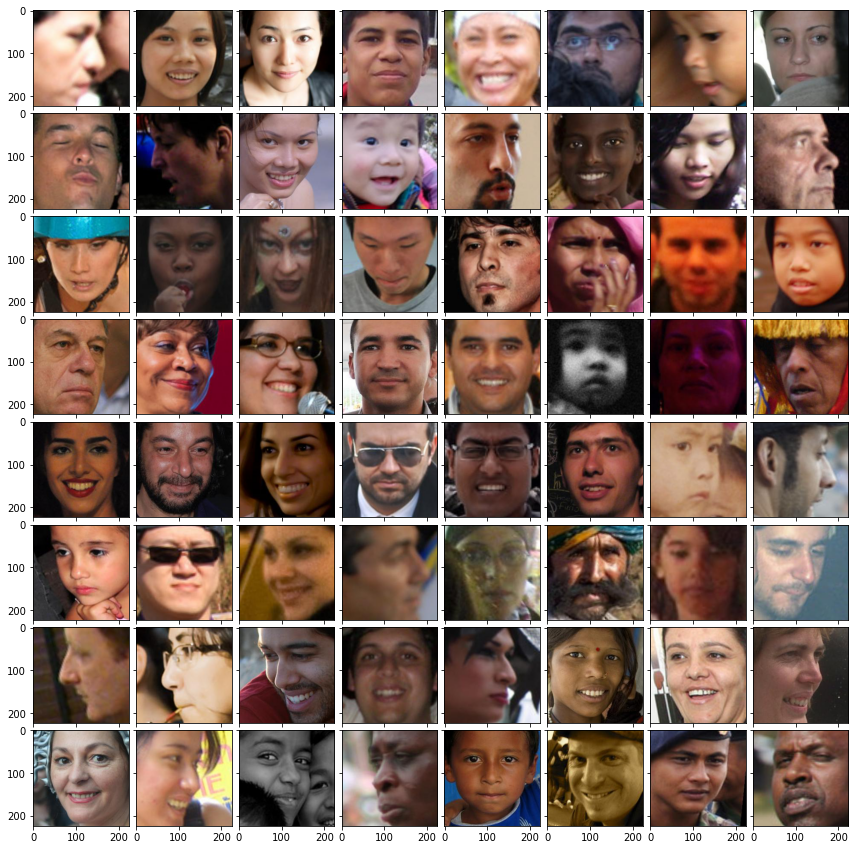

In [ ]:
fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(8, 8),  # creates 3x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                )

for (imgs, labels) in vis_iter:
    #set_trace()
    for ax, img in zip(grid, imgs):
        img = img.permute(1,2,0)
        plt.title(labels)
        ax.imshow(img.squeeze().numpy())
    break

In [ ]:
batch_size = 128

In [ ]:
print(batch_size)

128


In [ ]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [ ]:
test_loader = DataLoader(test_data,batch_size=batch_size, shuffle=True)

In [ ]:
len(test_data)

10954

# Loading the model
 uncomment model to train from the options. vgg16, vgg19, resnet18, resnet34 and alexnet.

In [ ]:

#model = models.alexnet(weights='IMAGENET1K_V1')
#model = models.resnet50(pretrained = True)
#model =models.vgg16(pretrained = True)
#model =models.vgg19(pretrained = True)



In [ ]:
#Load pretrained model
model =models.vgg16(pretrained = True)
#replace the last linear layer from classifier
last_layer = nn.Linear(4096,7)
model.classifier[6] = last_layer


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
#for resnet models replace the last linear layer from classifier using
#last_layer = nn.Linear(4096,7)
#model.classifier[6] = nn.Linear(512, 7)

In [ ]:
"""
uncomment to train resnet model

model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)


"""

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
model = model.to(device)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
device

device(type='cuda')

In [ ]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model, input_size=[1, 3, 224, 224]) # do a test pass through of an example input size 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 7]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

In [ ]:
class_map = {'Latino_Hispanic': 0,
             'East Asian': 1,
             'Indian': 2,
             'Middle Eastern': 3,
             'Black': 4,
             'Southeast Asian': 5,
             'White': 6
             }

# Define training parameters

In [ ]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
#scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
len(train_loader)

2711

In [ ]:
  # Put model in train mode
since = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
model.train()

PATH = '/content/gdrive/MyDrive/Colab Notebooks/vgg16_128_epochs.pth'

iter_ctr = 0
for epoch in range(20): 
    running_loss = 0.0
    running_corrects =0.0
    #set_trace()
    # Iterate over data.
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        #set_trace()
        iter_ctr +=1
       
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward      
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
      # preds = torch.argmax(torch.softmax(pred, dim=1), dim=1)
        loss = criterion(outputs, labels)

        # backward + optimize only if in training phase
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        #print(f'running losss: {running_loss}', end= " ")
        
        running_corrects += torch.sum(preds == labels)
       
        #print the loss for every 2000 iterations     
        if iter_ctr % 2000 == 1999:    
          # print every 2000 (twice per epoch) 
          print('[%d, %5d] loss: %.3f' %
                (epoch + 1, iter_ctr + 1, running_loss / 100))   
        
     #calculate the epoch loss and accuracy   
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_corrects.double() / len(train_loader)

    # save the best model state dictionary
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), PATH)

    print(f'{epoch} train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}=====>', end= "  ")
    #return epoch_loss, epoch_acc
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')


In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Load the saved models

In [3]:
path2 = "/content/gdrive/MyDrive/vgg16_model_29_epoch.pth"
resnet34_path = "/content/gdrive/MyDrive/Colab Notebooks/resnet34_30_epochs.pth"
PATH = '/content/gdrive/MyDrive/vgg16_50_epochs.pth'

In [7]:
"""
#load model trained on 50 epochs and batch size 
PATH = '/content/gdrive/MyDrive/vgg16_50_epochs.pth'
model=torch.load(PATH,map_location=torch.device('cpu'))
"""

In [9]:
#load model trained on cpu for  epochs
path2 = "/content/gdrive/MyDrive/vgg16_model_29_epoch.pth"
model=torch.load(path2)

In [ ]:
model.eval()

###### 

In [ ]:
#PATH = './alexnet.pth'
#
# Model class must be defined somewhere

torch_model=torch.load(path2)

In [ ]:
torch_model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Covert the model to onnx for use in other framework including matlab

In [ ]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_loader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

Single image shape: torch.Size([1, 3, 224, 224])



In [ ]:
torch_out = torch_model(img_single)

In [ ]:
torch_out

tensor([[  3.2893,  -2.7207,   2.1212, -12.3622,   4.5375,  16.8011, -12.2997]],
       grad_fn=<AddmmBackward0>)

In [ ]:
# Input to the model
x = torch.randn(batch_size, 1, 224, 224, requires_grad=True)
torch_out = torch_model(x)



In [ ]:
# Export the model
torch.onnx.export(torch_model,               # model being run
                  img_single,                         # model input (or a tuple for multiple inputs)
                  "/content/gdrive/MyDrive/Colab Notebooks/vgg16_29_epoch.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=11)

""",          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})"""

",          # the ONNX version to export the model to\n                  do_constant_folding=True,  # whether to execute constant folding for optimization\n                  input_names = ['input'],   # the model's input names\n                  output_names = ['output'], # the model's output names\n                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes\n                                'output' : {0 : 'batch_size'}})"

# Test the model

In [ ]:
model.eval()
correct = 0
total = 0

# Initialize the prediction and label lists(tensors)
#predlist=torch.zeros(0,dtype=torch.long, device='cpu')
#lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    #set_trace()
    for data in test_loader:
        images, labels = data
        #img =(color.gray2rgb(images))
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        #predlist=torch.cat([predlist,predicted.view(-1).cpu()])
       # lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


Accuracy of the network on the 10000 test images: 64 %


In [ ]:
# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

In [ ]:
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [ ]:
class_map = {0:'Latino_Hispanic',
             1:'East Asian',
             2:'Indian',
             3:'Middle Eastern',
             4:'Black',
             5:'Southeast Asian',
             6:'White'
             }

In [ ]:
model= (torch.load(path2))
model.to(device)
model.eval()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
classes =list(class_map.values())

In [ ]:
type(classes)

torch.Tensor

In [ ]:
len(test_loader)

343

In [ ]:

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
model.eval()
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    #for data in test_loader:
    
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader)):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Append batch prediction results
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

# Plot confusion matrix and classification report

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

[[ 714   63  178  161   98  131  278]
 [  61 1069   13   15   19  316   57]
 [ 197   17  899  107  173   65   58]
 [ 182   29   85  542   29   21  321]
 [  99   18   82   17 1264   49   27]
 [ 120  342   53   25   66  775   34]
 [ 250   98   42  183   33   34 1445]]
Accuracy of the network on the 10000 test images: 61 %


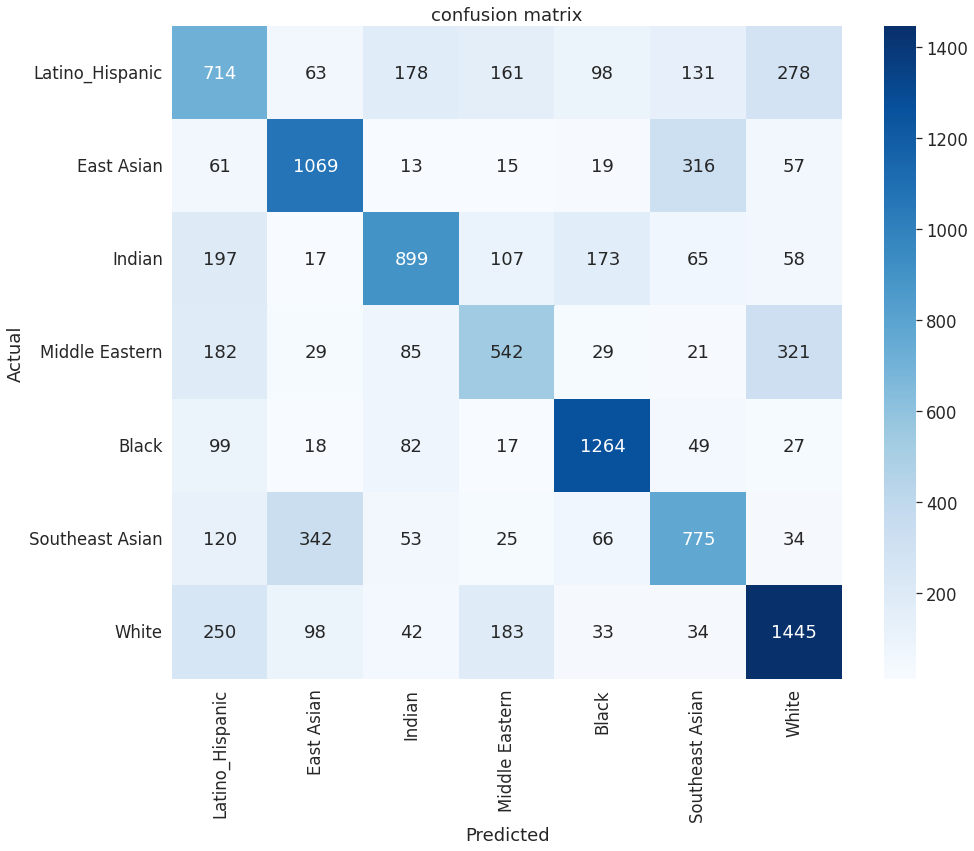

In [ ]:
import seaborn as sns
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (15, 12)
ax = sns.heatmap(conf_mat, fmt="d", annot=True, cmap='Blues',xticklabels =classes,yticklabels =classes)
plt.title("confusion matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(lbllist.numpy(), predlist.numpy(), target_names=classes))
#conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())

                 precision    recall  f1-score   support

Latino_Hispanic       0.44      0.44      0.44      1623
     East Asian       0.65      0.69      0.67      1550
         Indian       0.66      0.59      0.63      1516
 Middle Eastern       0.52      0.45      0.48      1209
          Black       0.75      0.81      0.78      1556
Southeast Asian       0.56      0.55      0.55      1415
          White       0.65      0.69      0.67      2085

       accuracy                           0.61     10954
      macro avg       0.60      0.60      0.60     10954
   weighted avg       0.61      0.61      0.61     10954



# ====================================================================

### **Aeuitas tool for detecting fairness and bias**

In [ ]:
!pip install aequitas 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.2 MB 4.4 MB/s 
     |████████████████████████████████| 456 kB 52.3 MB/s 
     |████████████████████████████████| 97 kB 6.9 MB/s 
     |████████████████████████████████| 83 kB 1.5 MB/s 
     |████████████████████████████████| 727 kB 47.0 MB/s 
     |████████████████████████████████| 45 kB 3.6 MB/s 
     |████████████████████████████████| 161 kB 64.5 MB/s 
     |████████████████████████████████| 216 kB 50.9 MB/s 
     |████████████████████████████████| 2.8 MB 44.2 MB/s 
     |████████████████████████████████| 3.1 MB 50.9 MB/s 
  Created wheel for Flask-Bootstrap: filename=Flask_Bootstrap-3.3.7.1-py3-none-any.whl size=460123 sha256=6a83828f1bbaa1f804bf4916aafa885bd50438296e5f779413f142568a1cdd06
  Stored in directory: /root/.cache/pip/wheels/67/a2/d6/50d039c9b59b4caca6d7b53839c8100354a52ab7553d2456eb
  Created wheel for markdown2: filename=markdown2-

In [ ]:
#import pandas as pd
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap

# import warnings; warnings.simplefilter('ignore')

%matplotlib inline

In [ ]:
csv_file="/content/gdrive/MyDrive/Colab Notebooks/data/fairface_label_train.csv"
df =pd.read_csv(csv_file)

**`df`**.head()

In [ ]:
df.head()

,file,age,gender,race,service_test
0,1.jpg,50-59,Male,East Asian,True
1,2.jpg,30-39,Female,Indian,False
2,3.jpg,03-Sep,Female,Black,False
3,4.jpg,20-29,Female,Indian,True
4,5.jpg,20-29,Female,Indian,True


In [ ]:
df.shape

(86744, 5)

In [ ]:
df.sort_values(by=['age'])

,file,age,gender,race,service_test
60341,60342.jpg,0-2,Female,White,False
13761,13762.jpg,0-2,Male,Southeast Asian,True
31986,31987.jpg,0-2,Male,East Asian,False
29007,29008.jpg,0-2,Male,Indian,False
13764,13765.jpg,0-2,Male,Black,False
...,...,...,...,...,...
75342,75343.jpg,more than 70,Male,Southeast Asian,False
3951,3952.jpg,more than 70,Female,Black,False
49452,49453.jpg,more than 70,Male,Black,True
65056,65057.jpg,more than 70,Male,Black,True


In [ ]:
aq_palette = sns.diverging_palette(10, 255, n=2)

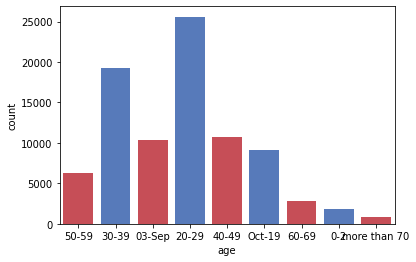

In [ ]:
by_age = sns.countplot(x="age", data=df, palette=aq_palette)

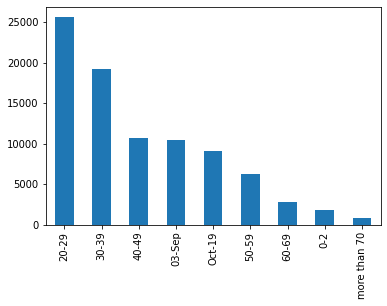

In [ ]:
df['age'].value_counts().plot(kind = 'bar')

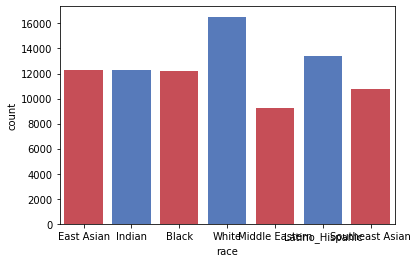

In [ ]:
by_gender = sns.countplot(x="race", data=df, palette=aq_palette)

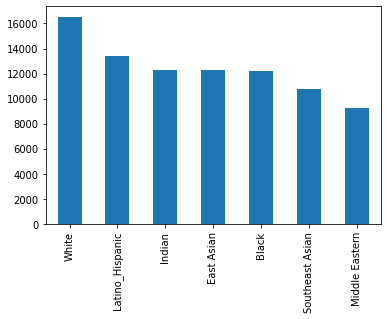

In [ ]:
df['race'].value_counts().plot(kind = 'bar')

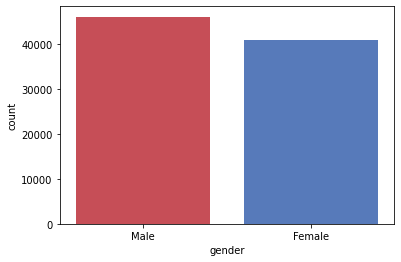

In [ ]:
by_gender = sns.countplot(x="gender", data=df, palette=aq_palette)

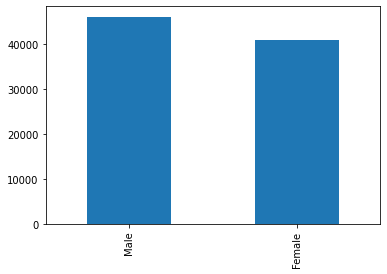

In [ ]:
df['gender'].value_counts().plot(kind = 'bar')

In [ ]:
df_ = df[['race','gender','age']]

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report